## Physics Informed Neural Networks to Approximate Solution of PDEs

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from utils.common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
# Physical constants
T_0 = 1
T_hot = 4
alpha_f = 0.05
alpha_s = 0.08
U_f = 1
h_f = 5
h_s = 6

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto R$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,
   
        $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [24]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42) # 2D Torch Tensor

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return torch.ones_like(x)


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)  # 1D Torch Tensor

        output_tb_f = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)
        output_tb_s = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        output_tb = torch.cat([output_tb_f,output_tb_s], dim = 1) # 2D Torch Tensor

        print('Temporal input', input_tb.shape)
        print('Temporal output', output_tb.shape)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0) # 1 D

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL) # 1 D




        #### TO CHANGE ####
        # Fluid: 0: Dirichlet, L: Derivative is 0
        output_sb_0_f = ((T_hot - T_0)/(1+torch.exp(-200*(input_sb_0[:,0]-0.25))))+T_0
        output_sb_L_f = torch.zeros((input_sb.shape[0], 1))

        # Solid: 
        output_sb_0_s = torch.zeros((input_sb.shape[0], 1))
        output_sb_L_s = torch.zeros((input_sb.shape[0], 1))

        # 0-BDC: Derivative is 0 on both sides 
        output_0 = torch.cat([output_sb_0_f.reshape(-1,1), output_sb_0_s], dim = 1)
        # L: BDC
        output_L = torch.cat([output_sb_L_f, output_sb_L_s], dim = 1)

        print('Spatial input', torch.cat([input_sb_0, input_sb_L], 0).shape)
        print('Spatial output', torch.cat([output_0, output_L], 0).shape)

        return input_sb_0, output_0,input_sb_L, output_L # Input: 1 D, output: 2 D



    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_0, output_0,input_sb_L, output_L = self.add_spatial_boundary_points()   # S_sb
        input_sb = torch.cat([input_sb_0, input_sb_L], dim = 1)
        output_sb = torch.cat([output_0, output_L], dim = 1) # Conc
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int




        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int



    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        # Find the approximate solutions
        T_f = self.approximate_solution(input_int)[:,0]
        T_s = self.approximate_solution(input_int)[:,1]
        # Find the gradients
        grad_T_f = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_T_f_t = grad_T_f[:, 0]
        grad_T_f_x = grad_T_f[:, 1]
        grad_T_f_xx = torch.autograd.grad(grad_T_f_x.sum(), input_int, create_graph=True)[0][:, 1]

        # Find the gradients
        grad_T_s = torch.autograd.grad(T_s.sum(), input_int, create_graph=True)[0]
        grad_T_s_t = grad_T_s[:, 0]
        grad_T_s_x = grad_T_s[:, 1]
        grad_T_s_xx = torch.autograd.grad(grad_T_s_x.sum(), input_int, create_graph=True)[0][:, 1]


        # Find the residuals:
        res_1 = grad_T_f_t+U_f*grad_T_f_x-alpha_f*grad_T_f_xx +h_f*(T_f-T_s)#*torch.ones_like(grad_T_f_t)
        res_2 = grad_T_s_t- alpha_s *grad_T_s_xx-h_s*(T_f-T_s)#*torch.ones_like(grad_T_s_t)
        
        res = torch.cat([res_1, res_2], dim = 0)
        

        return res.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, 
                     inp_train_tb, u_train_tb, 
                     inp_train_int, verbose=True):
        ## 1. Spatial Boundary residuals
        # Find the input
        inp_train_sb_0  = inp_train_sb[:, :2]
        inp_train_sb_L  = inp_train_sb[:, 2:]
        u_train_sb_0    = u_train_sb[:, :2]
        u_train_sb_L    = u_train_sb[:, 2:]

        inp_train_sb_0.requires_grad = True
        inp_train_sb_L.requires_grad = True

        ## Get predictions
        u_pred_sb_0 = self.approximate_solution(inp_train_sb_0)
        tf_0        = u_pred_sb_0[:, 0]
        ts_0        = u_pred_sb_0[:, 1]
        u_pred_sb_L = self.approximate_solution(inp_train_sb_L)
        tf_L        = u_pred_sb_L[:, 0]
        ts_L        = u_pred_sb_L[:, 1]

        # Compute gradients of the prediction to apply Neumann BDC
        grad_ts_0     = torch.autograd.grad(ts_0.sum(), inp_train_sb_0, create_graph=True)[0]
        grad_ts_0_x   = grad_ts_0[:,1]

        grad_tf_L     = torch.autograd.grad(tf_L.sum(), inp_train_sb_L, create_graph=True)[0]
        grad_tf_L_x   = grad_tf_L[:,1]
        grad_ts_L     = torch.autograd.grad(ts_L.sum(), inp_train_sb_L, create_graph=True)[0]
        grad_ts_L_x   = grad_ts_L[:,1]

        # Compute the residual 
        
        # Fluid
        r_sb_0f = tf_0 - u_train_sb_0[:, 0]# Dirichlet
        # Neumann
        r_sb_0s = grad_ts_0_x - u_train_sb_0[:, 1]# Neumann

        # Solid
        r_sb_Lf = grad_tf_L_x - u_train_sb_L[:, 0]# Neumann
        r_sb_Ls = grad_ts_L_x - u_train_sb_L[:, 1]# Neumann
        
        
        r_sb = torch.cat([r_sb_0f, r_sb_0s, r_sb_Lf, r_sb_Ls], dim=0)      

        # Initial conditions
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        r_tb = u_train_tb - u_pred_tb
        r_tb = r_tb.reshape(-1,)

        # Interior Residuals
        r_int = self.compute_pde_residual(inp_train_int)

        loss_int = torch.mean(abs(r_int) ** 2)

        loss_sb = torch.mean(abs(r_sb) ** 2) 
        loss_tb = torch.mean(abs(r_tb) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss



    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history


    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)
        output_tf = output[:,0]
        output_ts = output[:,1]
        #exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_ts.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("T_f")
        axs[1].set_title("T_s")

        plt.show()


In [25]:
n_int = 512
n_sb = 128
n_tb = 128

pinn = Pinns(n_int, n_sb, n_tb)

Spatial input torch.Size([256, 2])
Spatial output torch.Size([256, 2])
Temporal input torch.Size([128, 2])
Temporal output torch.Size([128, 2])


Spatial input torch.Size([256, 2])
Spatial output torch.Size([256, 2])
Temporal input torch.Size([128, 2])
Temporal output torch.Size([128, 2])


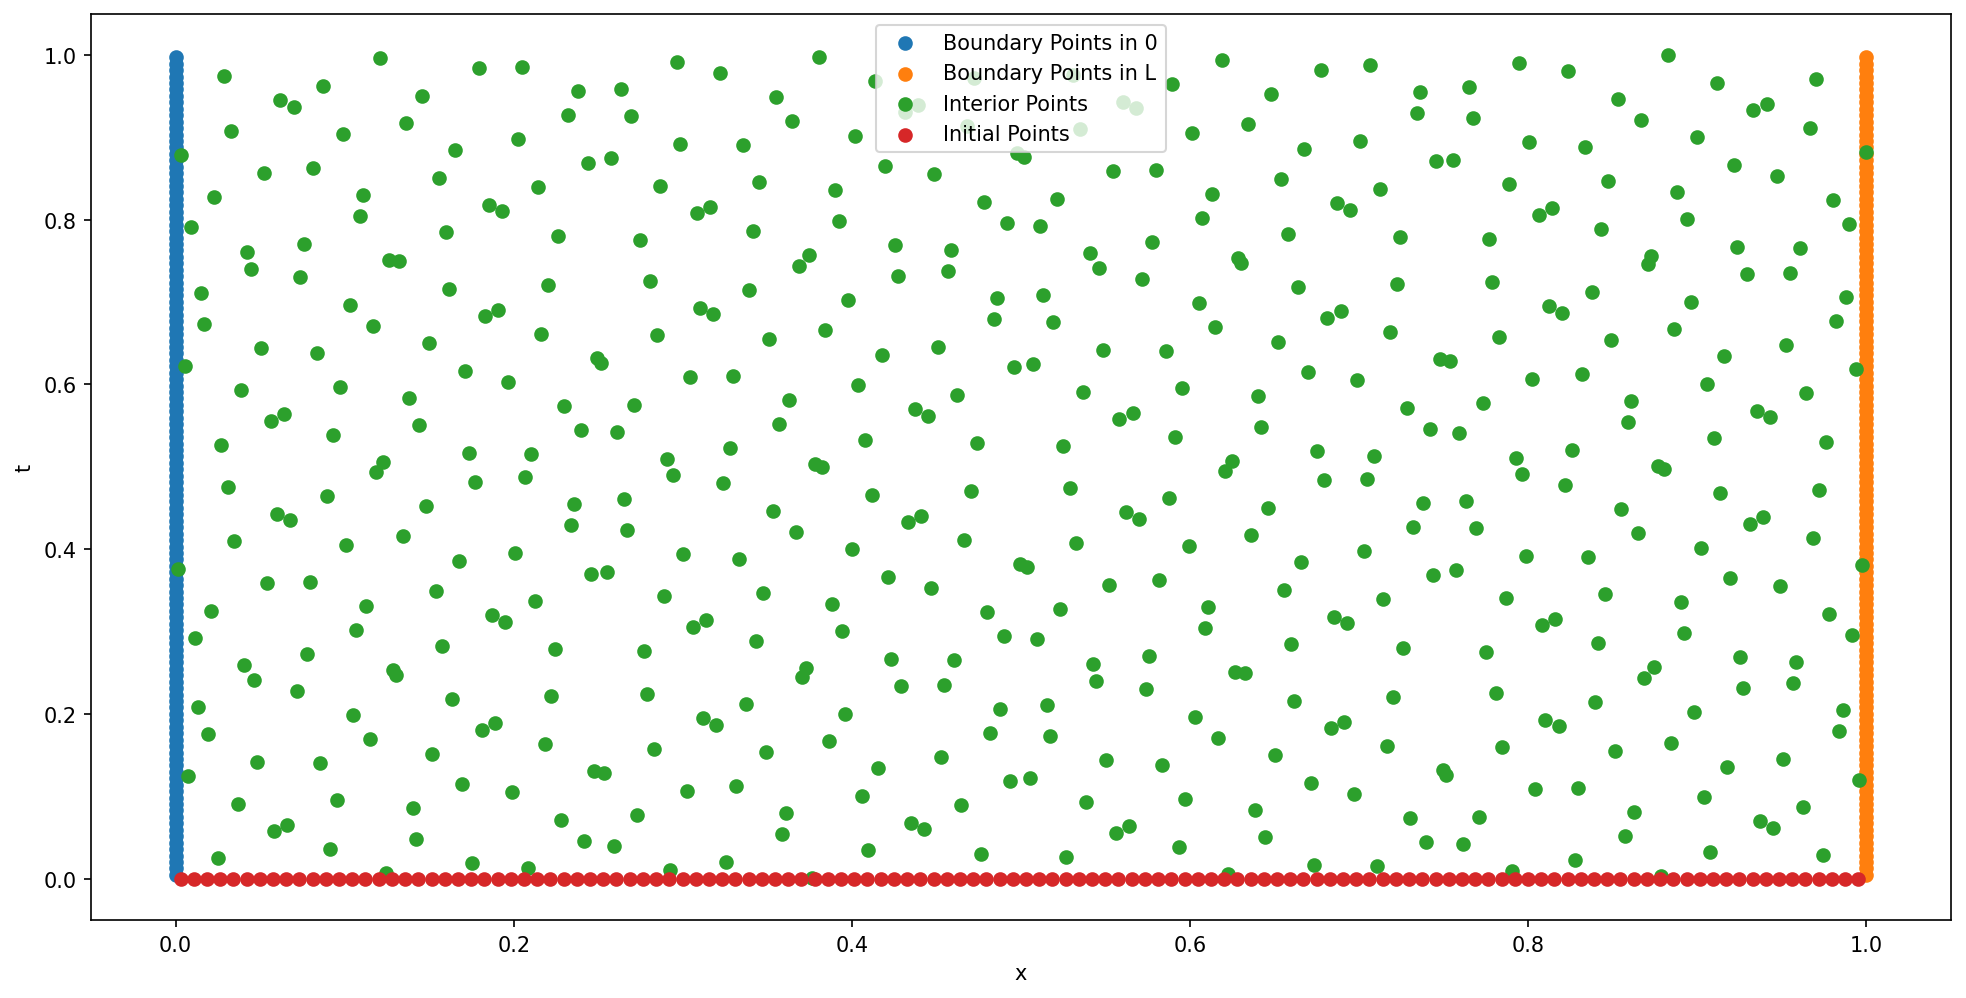

In [26]:
# Plot the input training points
input_sb_0, output_0,input_sb_L, output_L = pinn.add_spatial_boundary_points()   # S_sb
input_sb = torch.concat([input_sb_0, input_sb_L], dim = 1)
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()




plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_0[:,1].detach().numpy(), input_sb_0[:,0].detach().numpy(), label="Boundary Points in 0")
plt.scatter(input_sb_L[:,1].detach().numpy(), input_sb_L[:,0].detach().numpy(), label="Boundary Points in L")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [27]:
n_epochs = 10
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

Final Loss:  -4.021644592285156


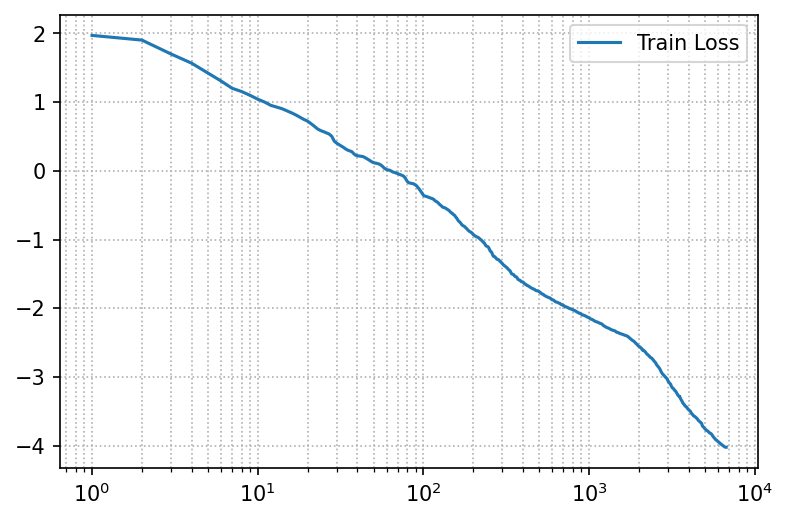

In [28]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=False)


plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

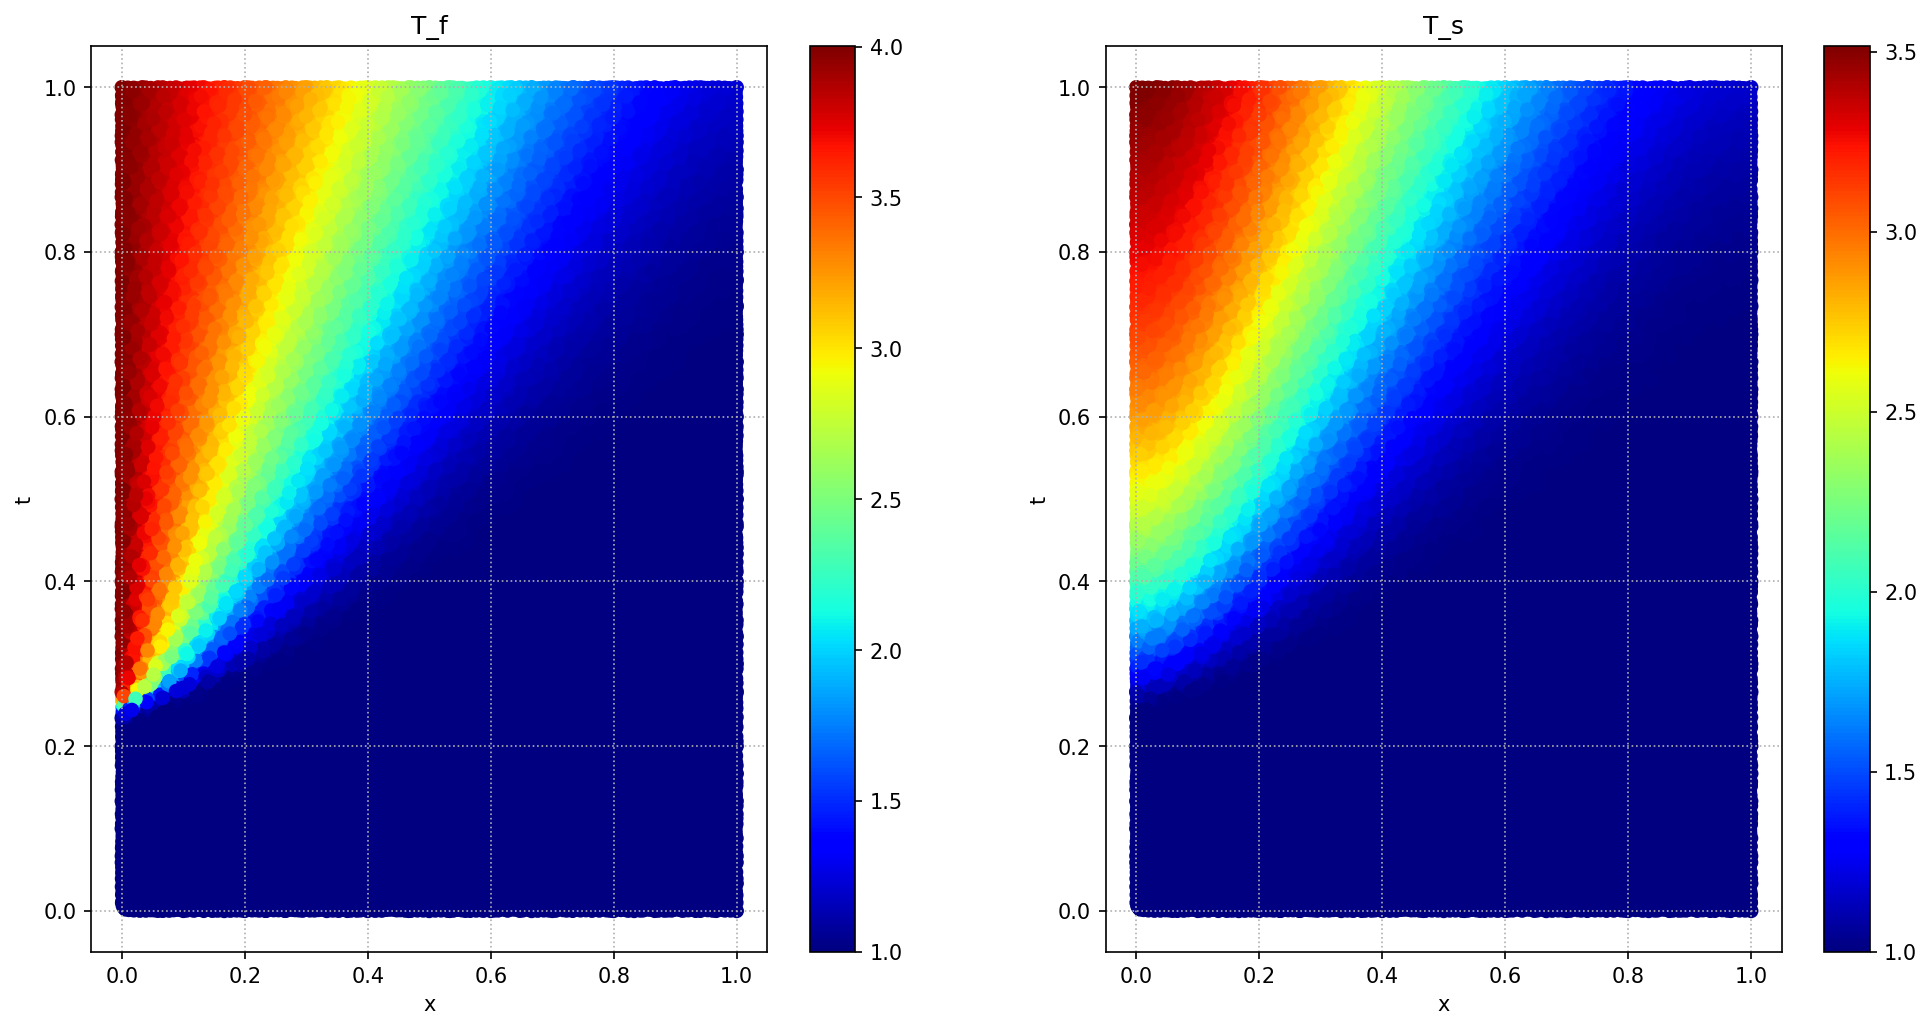

In [29]:
pinn.plotting()

In [30]:
import pandas as pd
test_input = pd.read_csv('Data/TestingData_Task6.txt')
test_input = torch.tensor(test_input.to_numpy().astype(np.float32))
result = pinn.approximate_solution(test_input)

test_input = test_input.detach().numpy()
result = result.detach().numpy()

final_np_array = np.concatenate([test_input, result], axis = 1)

In [31]:
'''with open('/Users/jonas/Documents/ETHZ/FS2022/Deep Learning for scientific computing/Project2/Task6/result_10epochs_more_points.txt', 'w') as f:
    f.write('t,x,tf,ts')
    f.write('\n')
    for idx in range(len(final_np_array)):
        t = final_np_array[idx,0]
        x = final_np_array[idx,1]
        tf = final_np_array[idx,2]
        ts = final_np_array[idx,3]
        line = str(t)+','+ str(x) + ',' + str(tf) + ',' + str(ts)
        f.write(line)
        f.write('\n')'''